In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_addons.optimizers import AdamW
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

In [5]:
num_classes = 4
input_shape = (224,224,3)

pickle_in = open("x.pickle","rb")
x = pickle.load(pickle_in)
x = np.array(x)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

print(f"x_train shape: {x_train.shape} - y_train sahe: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test sahe: {y_test.shape}")

x_train shape: (1076, 224, 224, 3) - y_train sahe: (1076,)
x_test shape: (462, 224, 224, 3) - y_test sahe: (462,)


In [6]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 100
image_size = 72 
patch_size = 6  
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  
transformer_layers = 8
mlp_head_units = [2048, 1024]  

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor = 0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)

In [8]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [9]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
    
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = "VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


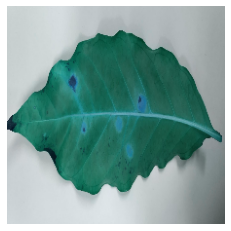

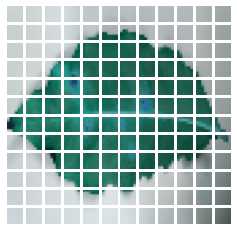

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
tf.convert_to_tensor([image]), size=(image_size, image_size))

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i , patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [11]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [12]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)

    augmented = data_augmentation(inputs)
    
    patches = Patches(patch_size)(augmented)

    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)


    for _ in range(transformer_layers):

        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [13]:
def run_experiment(model):
    optimizer = AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
16/16 [==============================] - 24s 285ms/step - loss: 6.2212 - accuracy: 0.3037 - val_loss: 1.8941 - val_accuracy: 0.3333
Epoch 2/100
16/16 [==============================] - 3s 208ms/step - loss: 2.1068 - accuracy: 0.3295 - val_loss: 1.2797 - val_accuracy: 0.3981
Epoch 3/100
16/16 [==============================] - 3s 199ms/step - loss: 1.5290 - accuracy: 0.3740 - val_loss: 1.1675 - val_accuracy: 0.4722
Epoch 4/100
16/16 [==============================] - 3s 199ms/step - loss: 1.4711 - accuracy: 0.3698 - val_loss: 1.1979 - val_accuracy: 0.4815
Epoch 5/100
16/16 [==============================] - 2s 140ms/step - loss: 1.4104 - accuracy: 0.4039 - val_loss: 1.2627 - val_accuracy: 0.3426
Epoch 6/100
16/16 [==============================] - 2s 139ms/step - loss: 1.3037 - accuracy: 0.4246 - val_loss: 1.1767 - val_accuracy: 0.4167
Epoch 7/100
16/16 [==============================] - 3s 190ms/step - loss: 1.1653 - accuracy: 0.4886 - val_loss: 0.9771 - val_accuracy: 0.657

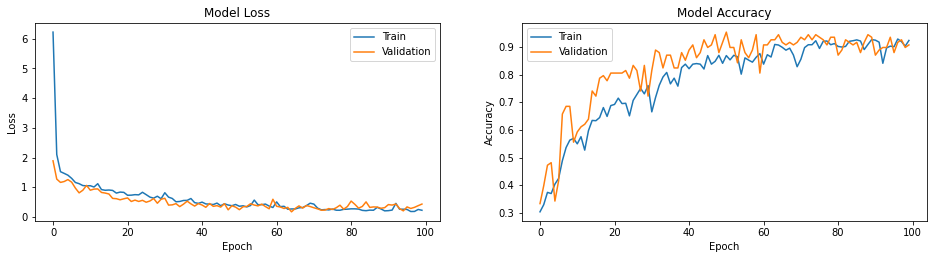

In [14]:
model_history = pd.DataFrame(history.history)

model_history_loss = model_history[['loss','val_loss']]
model_history_accuracy = model_history[['accuracy','val_accuracy']]

plt.figure(figsize=(16,8))

plt.subplot(2,2,1)   
plt.plot(model_history_loss)
plt.legend(['Train','Validation'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")

plt.subplot(2,2,2)
plt.plot(model_history_accuracy)
plt.legend(['Train','Validation'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")

plt.show()

In [15]:
y_pred = vit_classifier.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

conf_mat = confusion_matrix(y_test, y_pred)

15/15 [==============================] - 2s 33ms/step


In [16]:
columns = ['healthy','miner','rust','phoma']
conf_mat = pd.DataFrame(conf_mat,index=columns,columns=columns)

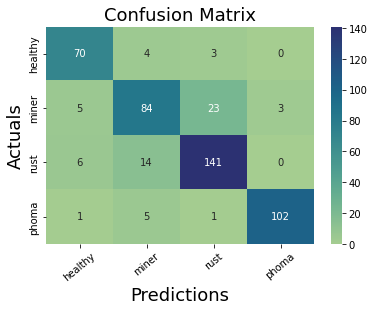

In [17]:
sns.heatmap(conf_mat,cmap='crest',cbar=True,annot=True,fmt='.3g')
plt.title("Confusion Matrix",fontsize=18)
plt.ylabel("Actuals",fontsize=18)
plt.xlabel("Predictions",fontsize=18)
plt.xticks(rotation=40)
plt.show()

In [18]:
vit_classifier.save_weights('model1.h5')